# Apuntes de Copernicus API - Introducción y True Color

El satélite Copernicus tiene una API para acceder a sus datasets, en concreto de Sentinel

# Introducción - Librerías y Autenticación

Librerías básicas: 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

#### Utils.py:

```python
"""
Utility functions used by example notebooks
"""
from typing import Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np


def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
```

### Autenticación: 

Aquí voy a usar mis claves.

    Nota: Para obtener las claves hay que registrarse en Copernicus e ir al perfil (donde el dashboard) y ahí ir a configuración. Te podrás abrir una ID para las claves API

In [3]:
config = SHConfig(
  instance_id='',
  sh_client_id='sh-528927c0-6d64-433b-93da-e2a2ee8274e4',
  sh_client_secret='RwUkYG8qZSox9NNRLl0jpoZ8F9ZUnRTP',
  sh_base_url='https://sh.dataspace.copernicus.eu',
  sh_auth_base_url=None,
  sh_token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

# Visualizaciones de imagenes de satélite

## Marcar zona de estudio

Antes que nada, que zona o extensión y a qué resolución queremos:

### Metodo de bounding box (BBox)


1. **BBox (Bounding Box):** 
   - En sistemas de información geográfica (SIG), una BBox es un rectángulo que encierra un área específica del mapa. Este rectángulo se define por las coordenadas de sus esquinas.
   - En este caso, las coordenadas están en el sistema `WGS84`, que es un estándar global para datos geoespaciales.
   - La BBox se define por dos pares de coordenadas: `[46.16, -16.15]` (esquina inferior izquierda) y `[46.51, -15.58]` (esquina superior derecha).

   - Estan en LONG y LAT 

2. **Obteniendo la BBox:**
   - Para obtener una BBox de una área diferente, puedes usar el sitio web [bboxfinder](http://bboxfinder.com/), que te permite seleccionar un área en el mapa y obtener sus coordenadas.

3. **Uso de la BBox en Solicitudes:**
   - Cuando se realizan solicitudes a ciertos servicios geoespaciales, es necesario especificar la BBox en un formato específico.
   - Aquí se requiere que la BBox se proporcione como una instancia de `sentinelhub.geometry.BBox` con un Sistema de Referencia de Coordenadas correspondiente (`sentinelhub.constants.CRS`).
   - El `WGS84` es un sistema de referencia de coordenadas estándar que se puede usar directamente desde `sentinelhub.constants.CRS`.

### Ejemplo: Monte del pardo

In [4]:
pardo_wgs84 = (-3.909490,40.459216,-3.666417,40.627233)

resolution = 10 # metros
pardo_bbox = BBox(bbox=pardo_wgs84, crs=CRS.WGS84) # Importante el crs si se usa otro
pardo_size = bbox_to_dimensions(pardo_bbox, resolution=resolution)

print(f"Tamaño de la imagen en {resolution} m resolución: {pardo_size} pixeles")

Tamaño de la imagen en 10 m resolución: (2075, 1847) pixeles


## Imagen True color en fecha:

Seguimos con el ejemplo del Pardo

Construimos la solicitud de acuerdo con la [Referencia de la API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), utilizando la clase `SentinelHubRequest`. Cada solicitud de la API de Procesos también necesita un [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript/V3.html).

La información que especificamos en el objeto `SentinelHubRequest` es:

 * un evalscript,
 * una lista de colecciones de datos de entrada con intervalo de tiempo,
 * un formato de la respuesta,
 * una BBox y su tamaño (tamaño o resolución).

El evalscript en el ejemplo se usa para seleccionar las bandas apropiadas. Devolvemos las bandas RGB (B04, B03, B02) del Sentinel-2 L1C.

La imagen del 12 de junio de 2020 se descarga. Sin parámetros adicionales en el evalscript, los datos descargados corresponderán a valores de reflectancia en formato `UINT8` (valores en el rango de 0 a 255).

### Explicación más detallada:

1. **Construcción de la Solicitud:**
   - Utilizamos la clase `SentinelHubRequest` para crear una solicitud de acuerdo con la documentación de la API de SentinelHub.
   - Cada solicitud que usamos con la API de Procesos necesita un `evalscript`.

2. **Evalscript:**
   - Un `evalscript` es un pequeño script que define cómo procesar y qué datos seleccionar de las imágenes satelitales.
   - En el ejemplo, el evalscript se utiliza para seleccionar las bandas RGB del satélite Sentinel-2, específicamente las bandas B04, B03 y B02.

3. **Información Especificada en `SentinelHubRequest`:**
   - **Evalscript:** El script que define qué datos necesitamos.
   - **Colecciones de Datos de Entrada:** Una lista de conjuntos de datos (por ejemplo, imágenes satelitales) y el intervalo de tiempo del cual se deben tomar estos datos.
   - **Formato de la Respuesta:** El formato en el que deseamos recibir los datos, como imágenes o datos numéricos.
   - **BBoxy su Tamaño:** La región específica del mapa que estamos interesados en analizar, junto con su tamaño o resolución deseada.

4. **Descarga de la Imagen:**
   - En el ejemplo, se descarga una imagen tomada el 12 de junio de 2020.
   - Sin parámetros adicionales en el evalscript, los datos descargados estarán en formato `UINT8`, que representa valores de reflectancia en un rango de 0 a 255.


In [5]:
# Evalscript:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

# Función de request
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url # ESTAR SEGUROS QUE EN SHCONFIG() LO HEMOS PUESTO
            ),
            time_interval=("2023-06-12", "2023-06-13"), # SELECCIONA LAS FECHAS
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=pardo_bbox, # PONER AQUI LA BBOX
    size=pardo_size, # Y SU RESOLUCION
    config=config,
)

Por último queda pedir la imagen con `request_true_color.get_data()`.

El método `get_data()` siempre devolverá una lista de longitud 1 con la imagen disponible del intervalo de tiempo solicitado en forma de arrays numpy.

Esto asegura que al utilizar el método `get_data()`, siempre se obtendrá una única imagen correspondiente al intervalo de tiempo solicitado, facilitando así el manejo de los datos devueltos.

In [6]:
pardo_truecolor = request_true_color.get_data()

print(
    f"El tipo de datos devueltos es = {type(pardo_truecolor)} y su longitud es {len(pardo_truecolor)}."
)
print(
    f"Un solo elemento en la lista es de tipo {type(pardo_truecolor[-1])} y tiene forma {pardo_truecolor[-1].shape}"
)

El tipo de datos devueltos es = <class 'list'> y su longitud es 1.
Un solo elemento en la lista es de tipo <class 'numpy.ndarray'> y tiene forma (1847, 2075, 3)


In [7]:
image = pardo_truecolor[0]
print(f"Image type: {image.dtype}")
print(f"Image type: {image.dtype}")
print(f"Image shape: {image.shape}")
print(f"Image min value: {image.min()}")
print(f"Image max value: {image.max()}")

Image type: uint8
Image type: uint8
Image shape: (1847, 2075, 3)
Image min value: 11
Image max value: 255


Ahora solo queda hacer el plot, con la función de ``utils.py``

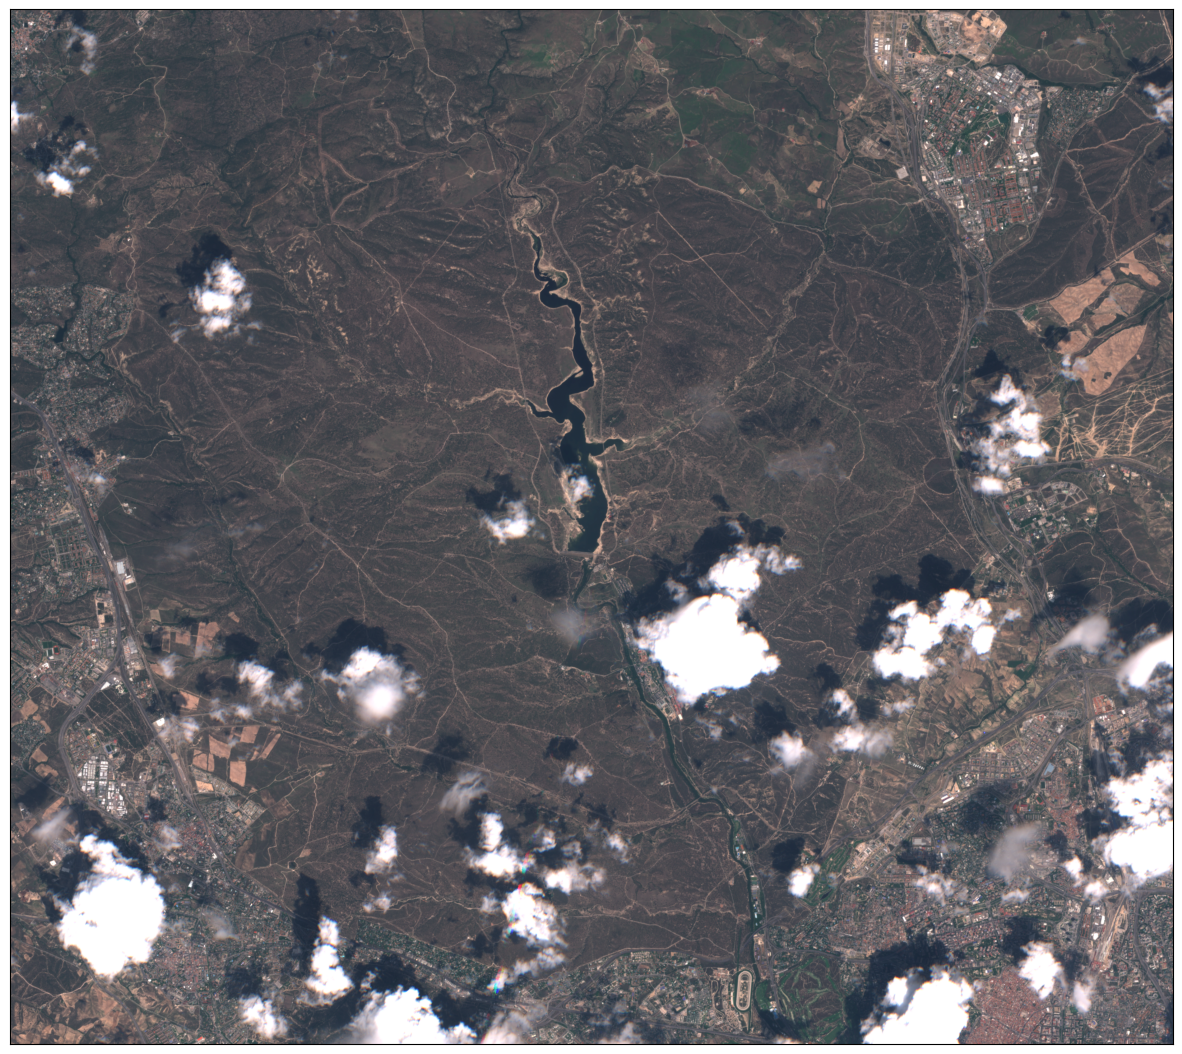

In [8]:
plot_image(image, factor=2.5 / 255, clip_range=(0, 1))

### Imagen sin nubes:

Claro, aquí tienes la traducción al español y una explicación más detallada:

La `SentinelHubRequest` crea automáticamente un mosaico de todas las imágenes disponibles en el intervalo de tiempo dado. Por defecto, se utiliza el orden de mosaico `mostRecent`. Más información disponible [aquí](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L1C.html#mosaickingorder).

En este ejemplo, proporcionaremos un intervalo de un mes, ordenaremos las imágenes con respecto a la cobertura de nubes a nivel de mosaico (parámetro `leastCC`), y las uniremos en el orden especificado.

In [9]:
pardo_sin_nubes = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=("2022-03-01", "2022-03-30"), # Intervalo de un mes, lo pongo en 2022 pq en 2023 se ve oscuro
            mosaicking_order=MosaickingOrder.LEAST_CC, # Que elija la que menos nubes tenga
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=pardo_bbox,
    size=pardo_size,
    config=config,
)

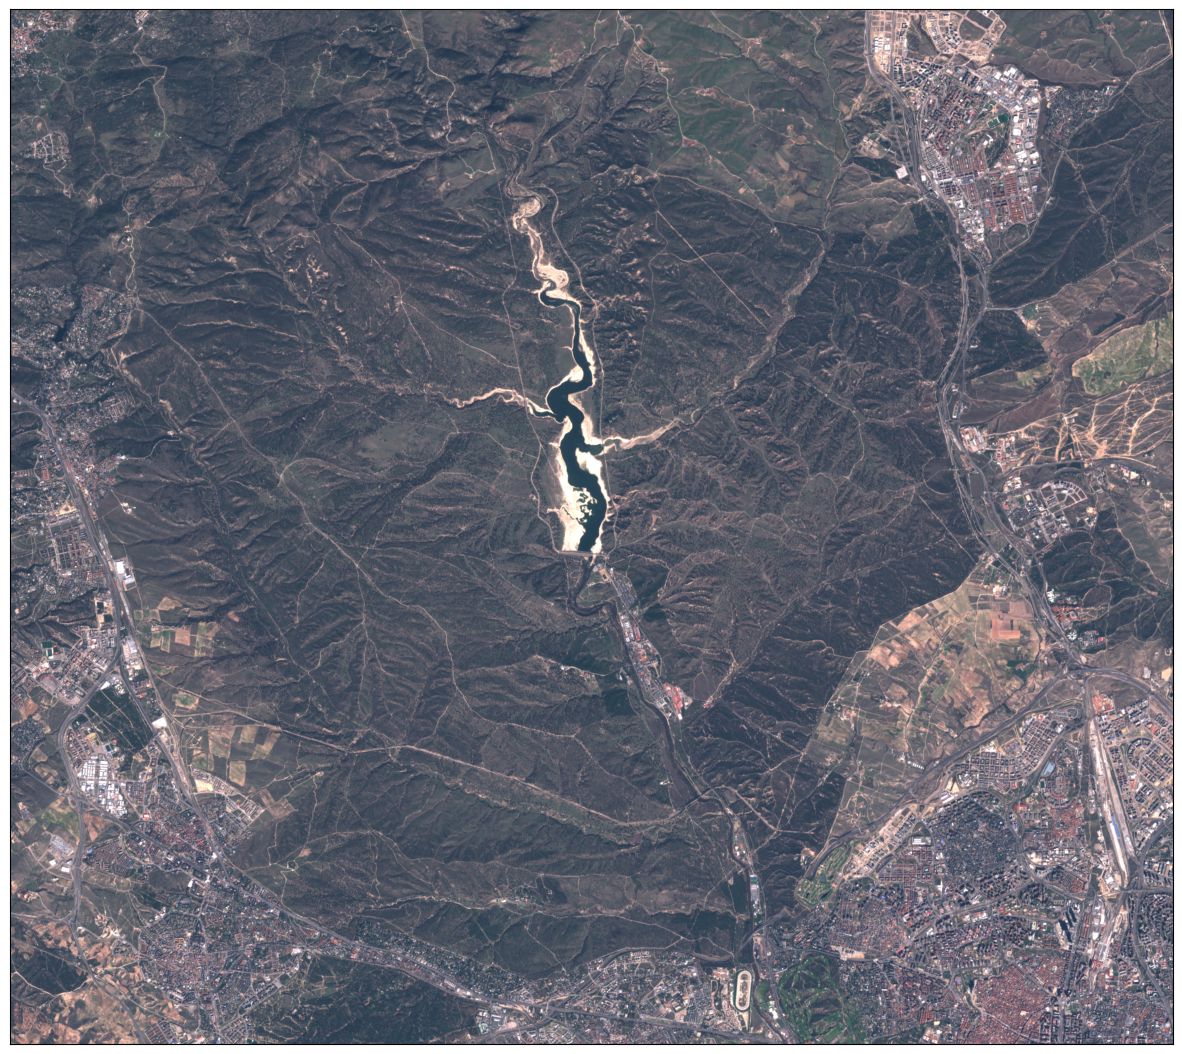

In [10]:
# Como ya sabemos las dimensiones de la imagen que nos puede dar, hacemos el plot directamente
plot_image(pardo_sin_nubes.get_data()[0], factor=4/ 255, clip_range=(0, 1))

# Todas las bandas de Sentinel

Vamos a hacer un evalscript que tenga todas las bandas de Sentinel para poder ver de todas las formas posibles el área de estudio. 

Ahora vamos a definir un evalscript que devolverá todas las bandas espectrales de Sentinel-2 con valores en bruto.

En este ejemplo, estamos descargando una cantidad bastante grande de datos, por lo que la optimización de la solicitud está regular. Descargar números digitales en bruto en el formato `INT16` en lugar de reflectancias en el formato `FLOAT32` significa que se descargan muchos menos datos, lo que resulta en una descarga más rápida y un menor uso de unidades de procesamiento de SH.

Para lograr esto, debemos establecer las unidades de entrada en el evalscript a `DN` (números digitales) y el argumento `sampleType` de salida a `INT16`. Además, no podemos empaquetar las 13 bandas de Sentinel-2 en una imagen `PNG`, por lo que debemos establecer el tipo de imagen de salida en el formato `TIFF` a través de `MimeType.TIFF` en la solicitud.

Los números digitales están en el rango de 0-10000, por lo que tenemos que escalar los datos descargados de manera apropiada.
Esto asegura que los datos descargados sean eficientes y manejables, optimizando el uso de recursos y tiempo en el proceso de descarga y análisis de las imágenes satelitales.

In [99]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "FLOAT32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ), # -------------------------------------------------------- LO MISMO VALE? --------------------------------
            time_interval=("2022-03-01", "2022-03-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=pardo_bbox,
    size=pardo_size,
    config=config,
)

Este va a tardar un poco más

In [ ]:
pardo_completo = request_all_bands.get_data()

In [ ]:
image = pardo_completo[0]
print(f"Image type: {image.dtype}")
print(f"Image type: {image.dtype}")
print(f"Image shape: {image.shape}")
print(f"Image min value: {image.min()}")
print(f"Image max value: {image.max()}")

## Prueba con SWIR: Banda 12

In [ ]:
# Image showing the SWIR band B12
# Factor 1/1e4 due to the DN band values in the range 0-10000
# Factor 3.5 to increase the brightness
plot_image(pardo_completo[0][:, :, 12], factor=3.5 / 1e4, vmax=1)

El SWIR es útil para la detección de humedad para la vegetación, ya que es sensisble al agua. 

El lago se ve muy bien, juntadolo con varias fechas podemos hacer una serie de como varía el nivel del agua a lo largo del tiempo.

## Prueba con Falso Color: Bandas 2, 3, 7

In [ ]:
plot_image(pardo_completo[0][:, :, [2, 3, 7]], factor = 3.5/1e4, clip_range = (0, 1))

### Prueba de máscara de lo que no es monte

In [ ]:
# Sacamos la imagen de falso color a una variable
fc = pardo_completo[0][:, :, [2, 3, 7]]

fc.dtype

In [ ]:
# Separar las bandas
blue_band = fc[:, :, 0]
green_band = fc[:, :, 1]
nir_band = fc[:, :, 2]

# Definir criterios para identificar áreas urbanas basados en los valores de las bandas
# Ajusta estos umbrales según las características específicas de tu imagen
urban_threshold_blue = 500  # Este umbral debe ajustarse según sea necesario
urban_threshold_green = 600  # Este umbral debe ajustarse según sea necesario
urban_threshold_nir = 1500  # Este umbral debe ajustarse según sea necesario

# Crear la máscara de áreas urbanas
urban_mask = (nir_band < urban_threshold_nir) & (blue_band > urban_threshold_blue) & (green_band > urban_threshold_green)

# Crear la máscara inversa (áreas no urbanas)
non_urban_mask = ~urban_mask

# Mostrar las máscaras en subplots alineados en la misma fila
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(urban_mask, cmap='turbo', vmin = 0, vmax = 1)
axes[0].set_title('Máscara de Áreas Urbanas')

axes[1].imshow(non_urban_mask, cmap='turbo')
axes[1].set_title('Máscara de Áreas No Urbanas')

plt.show()

In [98]:
ax = 1